# Mastering OpenAI Assistants API: Building an AI Financial Analyst to Forecast Stock Trend - By Yanli LIU
In this demo, we will create an AI Financial Analyst with the following essential capabilities:



1.   Answering General Finance Questions
2.   Guiding Through Financial Statements
3.   Conducting In-Depth Data Analysis
4.   Emailing Summaries and Key Insights

# Step 1 : Install necessary packages and set up environment

In [ ]:
!pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [ ]:
OPENAI_KEY="sk-xxxxx" # Your OPENAI API Key

We'll define also a pretty printing helper functions

In [ ]:
import json

def show_json(obj):
    display(json.loads(obj.model_dump_json()))

Define text wrapping

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

# Step 2: Create an Assistant

In [ ]:
from openai import OpenAI
client = OpenAI(api_key=OPENAI_KEY)

In [ ]:
assistant = client.beta.assistants.create(
    name = "Finance Insight Analyst",
    instructions = "You are a helpful  financial analyst expert and your are tailored for in-depth SEC 10-Q filings analysis, focusing on management discussions and financial results.",
    tools = [{"type":"code_interpreter"}, {"type": "retrieval"}],
    model = "gpt-4-1106-preview"
)

Regardless of whether you create your Assistant through the Dashboard or with the API, you'll want to keep track of the Assistant ID. This is how you'll refer to your Assistant throughout Threads and Runs.

In [ ]:
show_json(assistant)

{'id': 'asst_mGUIYqwif4EqRhUSBpDKtRkc',
 'created_at': 1700544757,
 'description': None,
 'file_ids': ['file-CZfGA5OmI93RzpHEaoNKIMxU'],
 'instructions': 'You are a helpful expert financial analyst and your are tailored for in-depth SEC 10-Q filings analysis, focusing on management discussions and financial results.',
 'metadata': {},
 'model': 'gpt-4-1106-preview',
 'name': 'Finance Insight Analyst',
 'object': 'assistant',
 'tools': [{'type': 'code_interpreter'},
  {'type': 'retrieval'},
  {'function': {'name': 'send_email',
    'parameters': {'type': 'object',
     'properties': {'email': {'type': 'string',
       'description': 'the email address of the user who receive the email'},
      'subject': {'type': 'string',
       'description': 'subject line of the email'},
      'textbody': {'type': 'string',
       'description': 'the body of the email.'}}},
    'description': 'A function that takes in a user email, a subject line and body text and sends an email to the email address 

In [ ]:
# FINANCE_ASSISTANT_ID = assistant.id  # or a hard-coded ID like "asst-..."
FINANCE_ASSISTANT_ID = "asst_mGUIYqwif4EqRhUSBpDKtRkc"

# Step 3: Create a Thread

We'll create a thread. The thread will hold the state of our conversation, so we don't have re-send the entire message history each time.

In [ ]:
thread1 = client.beta.threads.create()

# Step 4:  Submit a message to the thread, trigger the run, get the response

In this macro step, we'll combine the 3 follwing substeps :
1. Add Messages to the Thread as the user ask questions.
2. Run the Assistant on the Thread to trigger responses. This automatically calls the relevant tools.
3. Retrieve and display the Assistant's Response

To be noted that creating a Run is an asynchronous operation. It will return immediately with the Run's metadata, which includes a status that will initially be set to queued. The status will be updated as the Assistant performs operations (like using tools and adding messages).
To know when the Assistant has completed processing, we can poll the Run in a loop.

I've defined the following functions that I can reuse:


*   submit_message: submits a new user message to a thread and run the assistant on the thread
*   wait_on_run: this help us to to know when the Assistant has completed processing
get_respons

*   get_response: once the run is completed, we retrive the response from the thread.
*   pretty_print(messages):this helper function prints the user messages and assistants messages in a prettier way






In [ ]:
def submit_message(assistant_id, thread, user_message):
    client.beta.threads.messages.create(
        thread_id=thread.id, role="user", content=user_message
    )
    return client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant_id,
    )


import time
# Waiting in a loop
def wait_on_run(run, thread):
    while run.status == "queued" or run.status == "in_progress":
        run = client.beta.threads.runs.retrieve(
            thread_id=thread.id,
            run_id=run.id,
        )
        time.sleep(0.5)
    return run

def get_response(thread):
    return client.beta.threads.messages.list(thread_id=thread.id, order="asc")



# Step 5 : Get the response

This helper function prints the user messages and assistants messages in a prettier way

In [ ]:

# Pretty printing helper
def pretty_print(messages):
    print("# Messages")
    for m in messages:
        print(f"{m.role}: {m.content[0].text.value}")
    print()


Now, let's try out and  sumbit a message, trigger the run and get the responses once the run terminated

In [ ]:
run1 = submit_message(FINANCE_ASSISTANT_ID, thread1, "What is SEC Q-10 filing?")
run1 = wait_on_run(run1, thread1)
pretty_print(get_response(thread1))

# Messages
user: What is SEC Q-10 filing?
assistant: The SEC Form 10-Q is a comprehensive report of financial performance that must be submitted quarterly by all public companies to the Securities and Exchange Commission (SEC) in the United States. It provides a continuation of the financial information and disclosures required by the SEC and is a more frequent update on the company's financial position than the annual Form 10-K filing.

Key components of the 10-Q filing include:

1. **Financial Statements**: This section contains unaudited financial statements such as the balance sheet, income statement, statement of cash flows, and statement of stockholders' equity.

2. **Management's Discussion and Analysis of Financial Condition and Results of Operations (MD&A)**: Here, the company's management discusses the financial results and condition of the company, including any significant changes from the previous report, trends or risks that the company may be facing, and forward-looking 

In [ ]:
# Thank our assistant on Thread 1 :)
run2 = submit_message(FINANCE_ASSISTANT_ID, thread1, "Thank you!")
run2 = wait_on_run(run2, thread1)
pretty_print(get_response(thread1))

# Messages
user: What is SEC Q-10 filing?
assistant: The SEC Form 10-Q is a comprehensive report of financial performance that must be submitted quarterly by all public companies to the U.S. Securities and Exchange Commission (SEC). It is one of the many forms that public companies are required to file with the SEC.

The contents of the 10-Q include:

1. **Financial Statements**: This includes unaudited income statements, balance sheets, statement of cash flows, and statement of shareholders' equity. These statements provide a view of the company's financial health during the quarter.

2. **Management's Discussion and Analysis (MD&A)**: This section provides the company's perspective on the financial results, including explanations of the operations, new developments, and any known trends or uncertainties that the company is facing.

3. **Quantitative and Qualitative Disclosures about Market Risk**: This includes information about the company's exposure to market risk, such as interest

# Use case 1:  Asking questions on the file


In [ ]:
# Upload the file
file = client.files.create(
    file=open(
        "tsla-20231018-10Q.pdf",
        "rb",
    ),
    purpose="assistants",
)
# Update Assistant
assistant = client.beta.assistants.update(
    FINANCE_ASSISTANT_ID,
    file_ids=[file.id],
)
show_json(assistant)

{'id': 'asst_xiJ8bYNSctZMpwe7CJcC6iI1',
 'created_at': 1700335744,
 'description': None,
 'file_ids': ['file-CZfGA5OmI93RzpHEaoNKIMxU'],
 'instructions': 'You are a helpful expert financial analyst and your are tailored for in-depth SEC 10-Q filings analysis, focusing on management discussions and financial results.',
 'metadata': {},
 'model': 'gpt-4-1106-preview',
 'name': 'Finance Insight Analyst',
 'object': 'assistant',
 'tools': [{'type': 'code_interpreter'}, {'type': 'retrieval'}]}

Once the file is uploaded, it is persisted and we can find it though the following

In [ ]:
uploaded_files = client.files.list()
file_objects = list(filter(lambda x: x.filename == "tsla-20231018-10Q.pdf", uploaded_files.data))

if len(file_objects) > 0:
  file_id = file_objects[0].id

# if the_file_id:
#   delete_status = openai_client.files.delete(the_file_id)

Let's ask a question on the file

In [ ]:
thread = client.beta.threads.create()
run = submit_message(FINANCE_ASSISTANT_ID, thread, "Summarize the management discussion in this 10K filing and list key takeaways from this financial result")
run = wait_on_run(run, thread)
pretty_print(get_response(thread))

# Messages
user: Summarize the management discussion in this 10K filing and list key takeaways from this financial result
assistant: The management discussion section from the SEC 10-Q filing highlights several key aspects of the company's operations and outlook:

1. **Production Line Upgrades:** The company brought down several production lines for upgrades at various factories, which led to a sequential decline in production volumes.

2. **Delivery Rate Smoothing:** Efforts to smooth out the delivery rate across the quarter proved successful, with September accounting for approximately 40% of Q3 deliveries this year compared to 65% for the same period in the previous year【9†source】.

3. **Production Ramps and New Products:**
   - Pilot production of the Cybertruck has commenced at Gigafactory Texas with initial deliveries on track for the year.
   - The Model Y production rate in Texas is expected to grow gradually as the company ramps up additional supply chain needs.
   - The Gigaf

# Use Case 2: Asking questions requiring the code interpreter

1. Extract financial data in the file and save it in a CSV

In [ ]:
run = submit_message(FINANCE_ASSISTANT_ID, thread, "Can you extract the financial summary data et put it in CSV")
run = wait_on_run(run, thread)
messages = get_response(thread)

In [ ]:
file_path = messages.data[-1].content[0].text.annotations[0].file_path.file_id

file_name = client.files.with_raw_response.retrieve_content(file_path)
output_file_name = "data.csv"
with open(output_file_name, "wb") as file:
    file.write(file_name.content)


In [ ]:
import pandas as pd
df = pd.read_csv("data.csv")
df.head(12)

,Period,Total automotive revenues,Energy generation and storage revenue,Services and other revenue,Total revenues,Total gross profit,Total GAAP gross margin (%),Operating expenses,Income from operations,Operating margin (%),Adjusted EBITDA,Adjusted EBITDA margin (%),Net income attributable to common stockholders (GAAP),Net income attributable to common stockholders (non-GAAP),EPS attributable to common stockholders diluted (GAAP),EPS attributable to common stockholders diluted (non-GAAP),Net cash provided by operating activities,Capital expenditures,Free cash flow,"Cash, cash equivalents and investments"
0,Q3-2022,18692,1117,1645,21454,5382,25.1,1694,3688,17.2,4968,23.2,3292,3654,0.95,1.05,5100,-1803,3297,21107
1,Q4-2022,21307,1310,1701,24318,5777,23.8,1876,3901,16.0,5404,22.2,3687,4106,1.07,1.19,3278,-1858,1420,22185
2,Q1-2023,19963,1529,1837,23329,4511,19.3,1847,2664,11.4,4267,18.3,2513,2931,0.73,0.85,2513,-2072,441,22402
3,Q2-2023,21268,1509,2150,24927,4533,18.2,2134,2399,9.6,4653,18.7,2703,3148,0.78,0.91,3065,-2060,1005,23075
4,Q3-2023,19625,1559,2166,23350,4178,17.9,2414,1764,7.6,3758,16.1,1853,2318,0.53,0.66,3308,-2460,848,26077


2. Asking the assistant to draw a graph based on the data in the report

In [ ]:
thread3 = client.beta.threads.create()
run3 = submit_message(FINANCE_ASSISTANT_ID, thread3, "can you draw a graph based on operational margins in the file?")
run3 = wait_on_run(run3, thread3)
messages = get_response(thread3)

In [ ]:
show_json(messages)

{'data': [{'id': 'msg_nZbdVffwuuBXvrpF8faKbmzN',
   'assistant_id': None,
   'content': [{'text': {'annotations': [],
      'value': 'can you draw a graph based on operational margins in the file?'},
     'type': 'text'}],
   'created_at': 1700558862,
   'file_ids': [],
   'metadata': {},
   'object': 'thread.message',
   'role': 'user',
   'run_id': None,
   'thread_id': 'thread_JQMDQfBDnoW8yZIZ1PX4gxWV'},
  {'id': 'msg_Sna3NdRYdiUW2Rlcw7iuGBn0',
   'assistant_id': 'asst_mGUIYqwif4EqRhUSBpDKtRkc',
   'content': [{'image_file': {'file_id': 'file-UbMvp0LUw3SNp5Nm3fSnNAPZ'},
     'type': 'image_file'},
    {'text': {'annotations': [],
      'value': "Here is the graph depicting Tesla's operating margins over the last five quarters. As shown, the operating margin has decreased from 17.2% in Q3-2022 to 7.6% in Q3-2023【7†source】."},
     'type': 'text'}],
   'created_at': 1700558892,
   'file_ids': [],
   'metadata': {},
   'object': 'thread.message',
   'role': 'assistant',
   'run_id': 'r

In [ ]:
file_path = messages.data[-1].content[0].image_file.file_id

file_name = client.files.with_raw_response.retrieve_content(file_path)
output_file_name = "margin.png"
with open(output_file_name, "wb") as file:
    file.write(file_name.content)

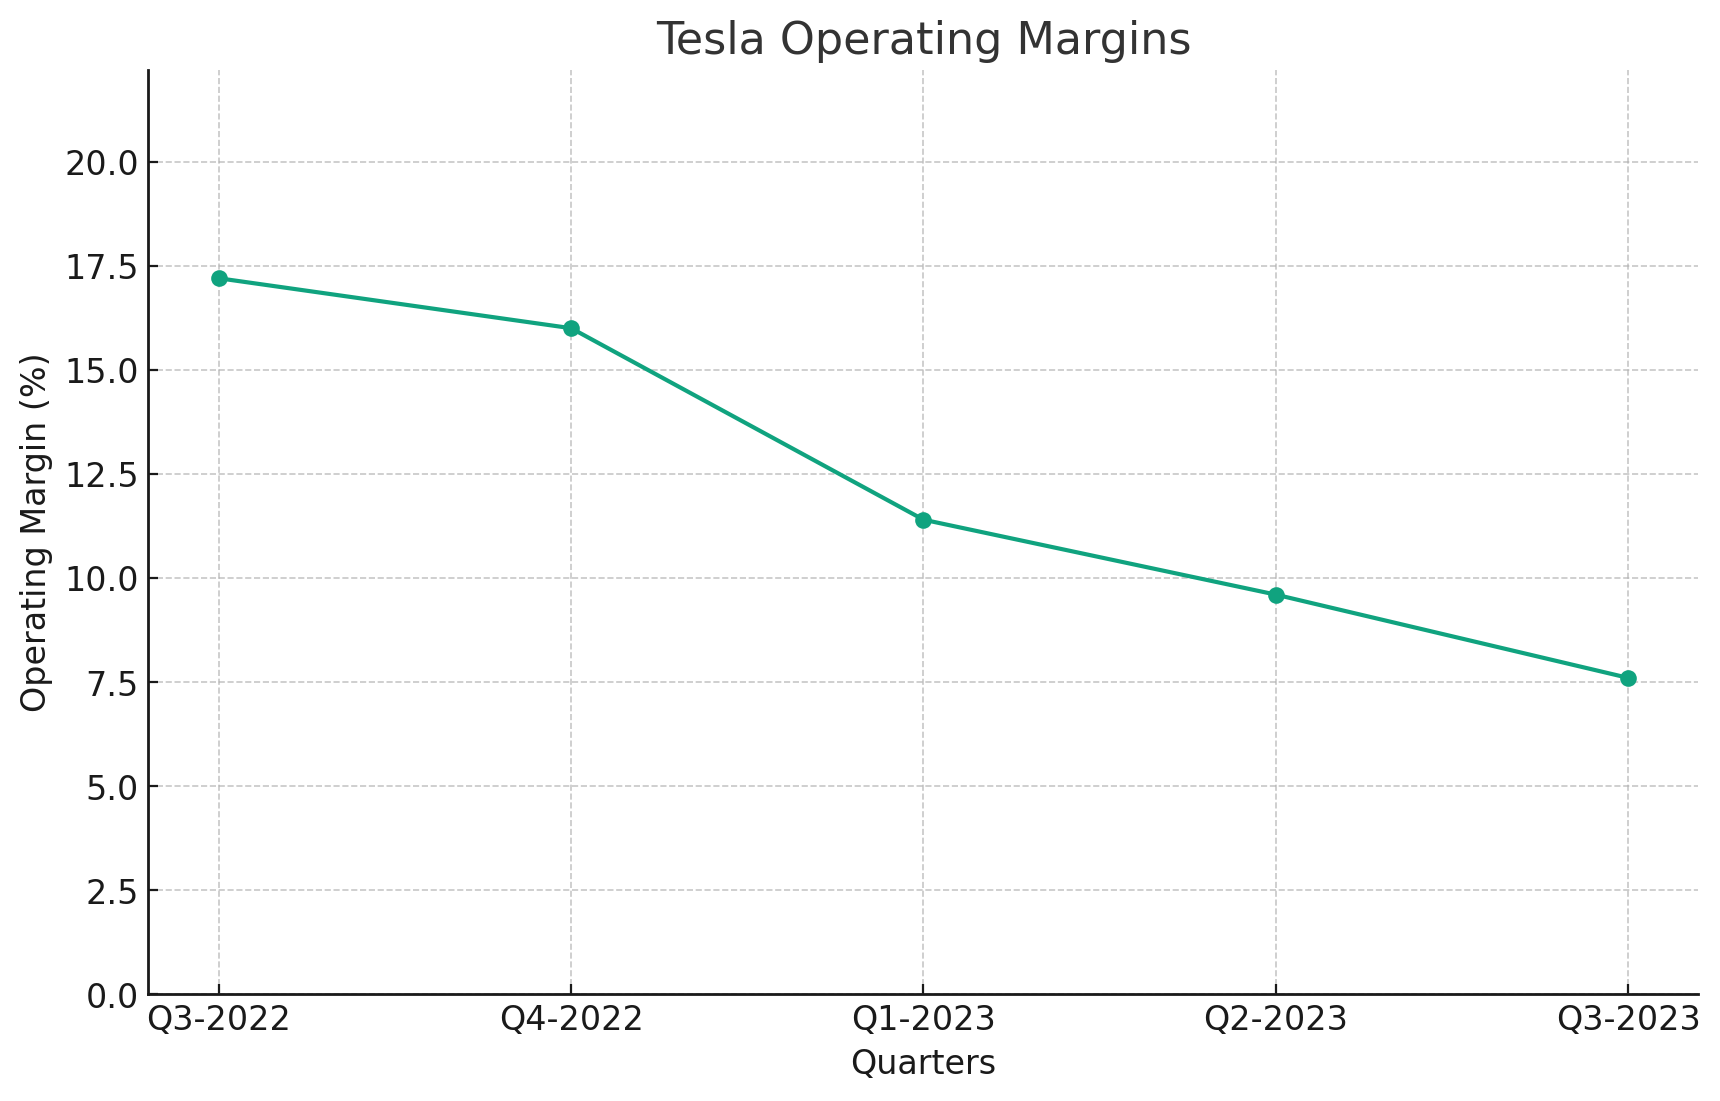

In [ ]:
from IPython.display import Image, display

# If your image is uploaded to the Colab environment
image_path = output_file_name
display(Image(filename=image_path))


# Use Case 3: Define a custom function to send the summary by email to the user

Define a custom function that can send the summary by email to the user

In [ ]:
def function_send_email(email, textbody, subject="Financial Statement Summary"):

  print("Email sent")

let's define the interface of this function in JSON format, so our Assistant can call it:

In [ ]:
function_send_email = {
    "name": "send_email",
    "description": "A function that takes in a user email, a subject line and body text and sends an email to the email address provided",
    "parameters":{
        "type":"object",
        "properties":{
            "email":{
                "type": "string",
                "description": "the email address of the user who receive the email"
            },
            "subject":{
                "type":"string",
                "description": "subject line of the email"

            },
            "textbody":{
                "type": "string",
                "description": "the body of the email."
            }
        }
    },
    "required":["email", "subject", "textbody"]
}

Update the assistant so it can have access to the function

In [ ]:
assistant = client.beta.assistants.update(
    FINANCE_ASSISTANT_ID,
    tools=[
        {"type": "code_interpreter"},
        {"type": "retrieval"},
        {"type": "function", "function": function_send_email},
    ],
)
show_json(assistant)

{'id': 'asst_mGUIYqwif4EqRhUSBpDKtRkc',
 'created_at': 1700544757,
 'description': None,
 'file_ids': ['file-CZfGA5OmI93RzpHEaoNKIMxU'],
 'instructions': 'You are a helpful expert financial analyst and your are tailored for in-depth SEC 10-Q filings analysis, focusing on management discussions and financial results.',
 'metadata': {},
 'model': 'gpt-4-1106-preview',
 'name': 'Finance Insight Analyst',
 'object': 'assistant',
 'tools': [{'type': 'code_interpreter'},
  {'type': 'retrieval'},
  {'function': {'name': 'send_email',
    'parameters': {'type': 'object',
     'properties': {'email': {'type': 'string',
       'description': 'the email address of the user who receive the email'},
      'subject': {'type': 'string',
       'description': 'subject line of the email'},
      'textbody': {'type': 'string',
       'description': 'the body of the email.'}}},
    'description': 'A function that takes in a user email, a subject line and body text and sends an email to the email address 

Update the wait_on_run function

In [ ]:
# Waiting in a loop
def wait_on_run(run, thread):
    while run.status == "queued" or run.status == "in_progress":
        run = client.beta.threads.runs.retrieve(
            thread_id=thread.id,
            run_id=run.id,
        )
        time.sleep(0.5)
    if run.status == "requires_action":
        tools_to_call = run.required_action.submit_tool_outputs.tool_calls
        print(len(tools_to_call))
        print(tools_to_call)

        tool_output_array = []

        for each_tool in tools_to_call:
          tool_id = each_tool.id
          function_name = each_tool.function.name
          function_arg = each_tool.function.arguments

          if function_name == "send_email":
            arguments = json.loads(function_arg)
            send_email(arguments["email"], arguments["subject"], arguments["textbody"])
            output = "Mail sent OK"
            tool_output_array.append({"tool_call_id": tool_id, "output": output})

        #Return results to the run operation
        run = client.beta.threads.runs.submit_tool_outputs(
          thread_id = thread.id,
          run_id = run.id,
          tool_outputs = tool_output_array
          )

    return run

Let's ask the assitant to send the summary by email to us

In [ ]:
assistant_id = "asst_mGUIYqwif4EqRhUSBpDKtRkc"

thread =  client.beta.threads.create()
run = submit_message(assistant_id, thread, "Can you send the summary to the mail: abc@gmail.com")
run = wait_on_run(run, thread)

1
[RequiredActionFunctionToolCall(id='call_NHNPDyRLuXqtIKK1oDSfcnSS', function=Function(arguments='{\n  "email": "ronal999.liu@gmail.com",\n  "subject": "Tesla Q3 2023 10-Q Filing Summary",\n  "textbody": "Dear recipient,\\n\\nPlease find below the summary of the Tesla Q3 2023 10-Q filing:\\n\\nSummary Highlights from Q3 2023:\\n- Operating margin stood at 7.6%.\\n- GAAP operating income reached $1.8 billion.\\n- GAAP net income was $1.9 billion.\\n- Non-GAAP net income amounted to $2.3 billion.\\n- A strong emphasis was placed on reducing costs per vehicle, generating free cash flow, maximizing delivery volumes, and investing in AI and other growth projects.\\n- Cost of goods sold per vehicle dropped to approximately $37,500.\\n- Tesla continues to strive to be a cost leader in the industry.\\n- Free cash flow achieved so far was $2.3 billion, with a quarter-over-quarter increase in cash and investments by $3.0 billion to $26.1 billion.\\n- AI training compute capacity more than doubl

In [ ]:
show_json(run)

{'id': 'run_1xt9oTpQVBPJMVaKgnVkyAQN',
 'assistant_id': 'asst_mGUIYqwif4EqRhUSBpDKtRkc',
 'cancelled_at': None,
 'completed_at': None,
 'created_at': 1700554831,
 'expires_at': 1700555431,
 'failed_at': None,
 'file_ids': ['file-CZfGA5OmI93RzpHEaoNKIMxU'],
 'instructions': 'You are a helpful expert financial analyst and your are tailored for in-depth SEC 10-Q filings analysis, focusing on management discussions and financial results.',
 'last_error': None,
 'metadata': {},
 'model': 'gpt-4-1106-preview',
 'object': 'thread.run',
 'required_action': None,
 'started_at': 1700554832,
 'status': 'queued',
 'thread_id': 'thread_UwsWUF6VhqFCUoTPExR6y7Ae',
 'tools': [{'type': 'code_interpreter'},
  {'type': 'retrieval'},
  {'function': {'name': 'send_email',
    'parameters': {'type': 'object',
     'properties': {'email': {'type': 'string',
       'description': 'the email address of the user who receive the email'},
      'subject': {'type': 'string',
       'description': 'subject line of 

In [ ]:
pretty_print(get_response(thread))

# Messages
user: Can you send the summary to the mail: ronal999.liu@gmail.com
assistant: I will proceed to analyze the SEC 10-Q filing and provide a summary. Once I have the summary prepared, I will use the given email address to send the summary to you. Please give me a moment to review the document.
assistant: I have gathered information about Tesla's 10-Q filing as summarized below:

**Summary Highlights from Q3 2023**:
- Operating margin stood at 7.6%.
- GAAP operating income reached $1.8 billion.
- GAAP net income was $1.9 billion.
- Non-GAAP net income amounted to $2.3 billion.
- A strong emphasis was placed on reducing costs per vehicle, generating free cash flow, maximizing delivery volumes, and investing in AI and other growth projects.
- Cost of goods sold per vehicle dropped to approximately $37,500.
- Tesla continues to strive to be a cost leader in the industry.
- Free cash flow achieved so far was $2.3 billion, with a quarter-over-quarter increase in cash and investments 